#Progetto Applicazioni Data Intensive

Autore: Antonio delle Canne

Mail istituzionale: antonio.dellecanne@studio.unibo.it

Matricola: 0000882102

# Predizione dell'indice di borsa

Si vuole realizzare un modello che, dati in input una serie di dati su una security all'inizio della giornata, sia in grado di predire il valore assunto da questa alla fine della giornata, al fine di implementare un'algoritmo di trading che venda e compri stock a seconda del valore predetto dal modello per generare un rpofitto.

Per fare ciò alleniamo il modello sui dati di mercato passati, relativi allo stock su cui vogliamo effettuare predizioni.

Si tratta quinid della predizione di una variabile continua, e quindi di un problema di regressione.

# Import delle librerie necessarie

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [303]:
pip install yfinance

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import yfinance
from pandas import Series
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from IPython.display import display

# Raccolta dati e analisi esplorativa

Carichiamo i dati da YahooFinance utilizzando l'API yfinance.
Questa fornisce dati storici su un'ampia gamma di stock, e permette di ottenerli in dataframe Pandas.

Da questa API otteniamo le seguenti informazioni indicizzare per data(YYYY-MM-DD):

 - `Open`: valore della security al momento dell'apertua del mercato
 
 - `Close`: valore della security al momento della chiusura del mercato
 
 - `Low`: valore minimo che la security ha raggiunto durante la gionrata
 
 - `High`: valore massimo che la security ha raggiunto durante la gionrata 
 
 - `Volume`: numero di transazioni eseguite sulle security dello stock al momento della chiusura del mercato. Nella scelta dello stock, ne volgiamo considerare uno che abbia un volume abbastanza alto, in modod da facilitare le transazioni.

In questa analisi utilizziamo i dati di Amazon, dal 2012 al 2018.

In [0]:
start_date = "2012-01-01"
end_date = "2018-12-31"
security = yfinance.Ticker("AMZN") #Amazon
security_data = security.history(start=start_date, end=end_date, actions=False)

In [306]:
security_data.describe()

Open         High          Low        Close        Volume
count  1759.000000  1759.000000  1759.000000  1759.000000  1.759000e+03
mean    662.278158   668.754849   654.573320   661.929864  4.045698e+06
std     478.320815   483.058999   471.762531   477.433157  2.355180e+06
min     173.810000   178.250000   172.000000   175.930000  9.844000e+05
25%     300.000000   303.730000   296.395000   299.785000  2.630450e+06
50%     439.350000   444.720000   435.580000   439.390000  3.427400e+06
75%     875.975000   883.705000   874.155000   880.505000  4.629250e+06
max    2038.110000  2050.500000  2013.000000  2039.510000  2.385610e+07

In [0]:
#per essereconsiderata nella nostra analisi, una feature deve essere disponibile alkl'inizio della giornata, se cosi' non e',
#possiamo considerarne i valori delle gionrate passate usando il metodo shift dei dataframe e delle serie pandas

open = security_data["Open"] #disponibile all'apertura
high = security_data["High"] #non disponibile all'apertura
low = security_data["Low"] #non disponibile all'apertura
close = security_data["Close"] #non disponibile all'apertura
volume = security_data["Volume"] #non disponibile all'apertura

## Descrizione dell'algoritmo di trading

L'algoritmo di trading usato e' il seguente:
- Se all'inizio della giornata il modello prevede che il valore di chiusura della security sara' piu' basso di quello di apertura, la venderemo e laricompreremo a fine giornata
- Se all'inizio della giornata il modello prevede che il valore di chiusura della security sara' piu' alto di quello di apertura, terremo la security e la venderemo a fine gionrata

Per far si che la predizione sia piu'efficente, invece di predire in valore assoluto di chiusura e confrontarlo con quello di apertura, si puo' predire la differenza tra valore di chiusura e aperutra nel seguente modo:
$\Delta_d=C_d-O_d$, dove $C_d$ e' il valore di chiusura giornaliero e $O_d$ quello di apertura 

In [0]:
delta = close - open #variabile da predire

## Estrazione delle Features

Invece di predire direttamente il prezzo di chiusura dello 

Dai valori forniti da YahooFinance, possiamo ricavare le seguenti features

In [0]:
sma_delta = delta.shift(1).rolling(window=50).mean() #simple moving average della variabile da predire calcolato sugli ultimi 50 giorni
delta_vs_sma = delta - sma_delta #differenza tra delta e il simple moving average di delta
hlm = (high + low) / 2 #prezzo medio dello stock
sma_price = hlm.shift(1).rolling(window=50).mean() #simple moving average del prezzo
price_vs_sma = hlm - sma_price #differenza tra il prezzo e il simple moving average del prezzo
sma_volume = volume.shift(1).rolling(window=50).mean() #simple moving average del volume
volume_vs_sma = volume - sma_volume #differenza tra il volume e il simple moving average del volume

## Analisi delle feature

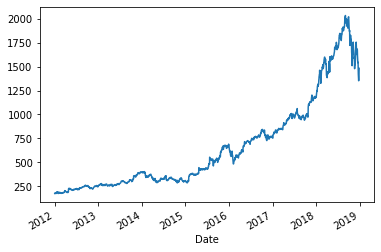

In [310]:
hlm.plot(label="market prices")

In [311]:
delta.var()

186.90687012710828

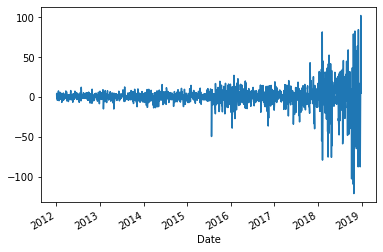

In [312]:
delta.plot()

## Analisi delle diverse features in correlazione con delta
Per studiare la correlazione tra features analizziamo un periodo di tempo ristretto, in modod che il grafico sia facilemtne interpretabile

In [0]:
start = -500
stop = -200
period = slice(start, stop)

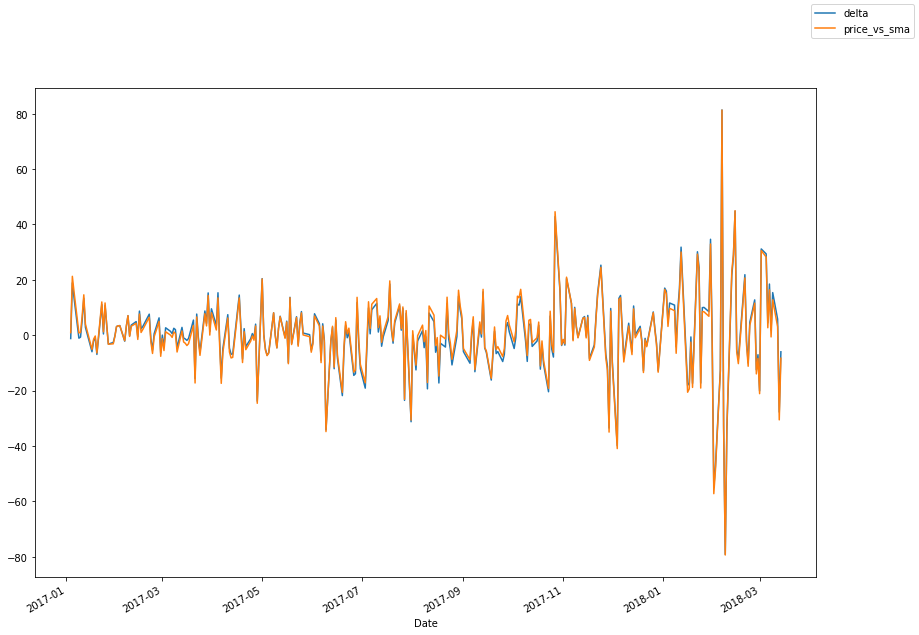

In [314]:
#dal grafico vediamo che c'e' correlazione tra delta_vs_sma e delta, quindi teniamo delta_vs_sma
figure = plt.figure(figsize=(14, 10))
delta[period].plot(label="delta")
delta_vs_sma[period].plot(label="price_vs_sma")
figure.legend()

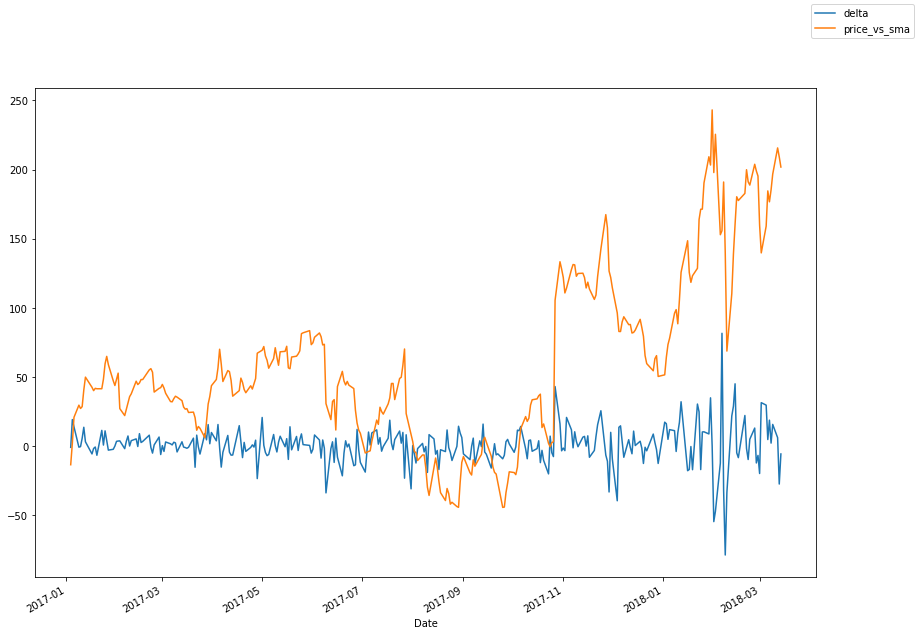

In [315]:
#dal grafico vediamo che puo' esserci correlazione tra price_vs_sma e delta, quindi teniamo volume_vs_sma
figure = plt.figure(figsize=(14, 10))
delta[period].plot(label="delta")
price_vs_sma[period].plot(label="price_vs_sma")
figure.legend()

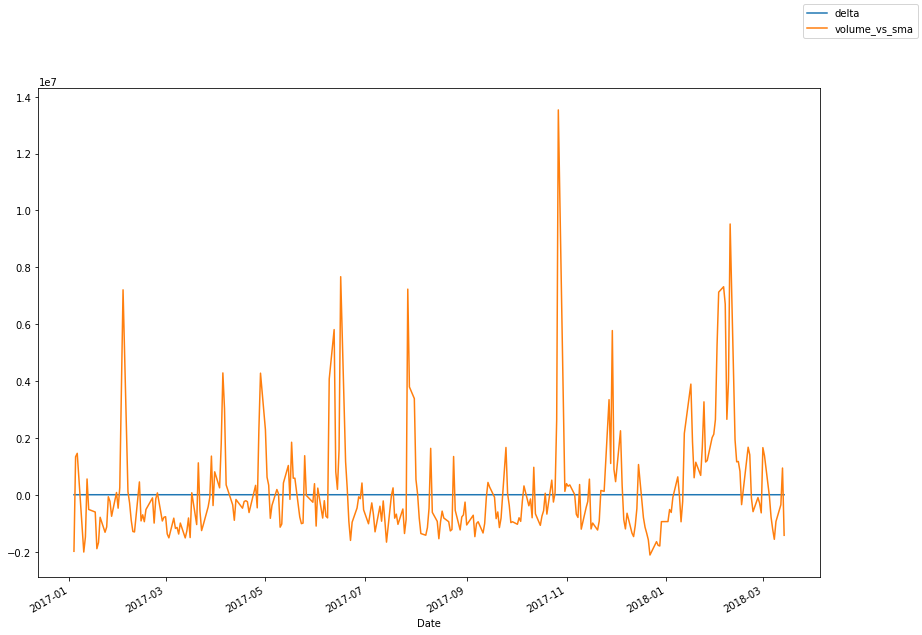

In [316]:
#dal grafico vediamo che non c'e' correlazione tra volume_vs_sma e delta, quindi scartiamo volume_vs_sma
period = slice(start, stop)
figure = plt.figure(figsize=(14, 10))
delta[period].plot(label="delta")
volume_vs_sma[period].plot(label="volume_vs_sma")
figure.legend()

# Allenamento modello

## Metriche
Come metrica principale per valutare la bonta' dele predizioni utilizzeremo il Return of Investment (ROI).

Con questa metrica assumiamo di utilizzare l'algoritmo di trading precedentemente descritto, e calcoliamo il guadango che avremmo ottenuto se lo avessimo utilizzato sul dataset che stiamo valutando.

In [0]:
def gain(D, D_pred):
    growth = D_pred > 0
    decline = D_pred < 0
    return D[growth].sum() - D[decline].sum()
def roi(D, D_pred):
    mean_open = open.reindex_like(D).mean()
    return gain(D, D_pred) / mean_open

## Preparazione dei dati
Come spiegato in precedenza, visto che alcune feature non sono disponibili all'inizio della giornata, per poterle utilizzare nel nostro modello, utilizzeremo i dati dei giori passati, servendoci della funzione shift.

Visto che l'utilizzo di questa funzione fara' si che in alcune riche vi saranno dei vaolri NaN, dobbiamo assicurarci di eliminare queste osservazioni sia nelle serie relative ale features che in quella della variabile da predire.
Questo compito e' svolto dalla funzione prepare_data.

In [0]:
def prepare_data(features, target):
    X = pd.DataFrame(features)
    X.dropna(inplace=True)
    y = target.reindex_like(X)
    return X, y

Con la funzione split_before_2015, dividiamo il dataset mettendo nel training set tutti i dati precedenti al 2015, e i restanti nel validation set.

In [0]:
def split_before_2015(X, y):
    is_train = X.index.year < 2015
    X_train = X.loc[is_train]
    y_train = y.loc[is_train]
    X_val = X.loc[~is_train]
    y_val = y.loc[~is_train]
    return X_train, X_val, y_train, y_val

## Individuazione delle features piu' rilevanti
Per individuare le feature piu' rilevanti usiamo la regressione Lasso e vediamo quali features non vengono escluse.

In [0]:
features = {}
for i in range(1, 4):
    features["DeltaLag{}".format(i)] = delta.shift(i)
for i in range(1, 4):
    features["DeltaSMALag{}".format(i)] = sma_delta.shift(i)
for i in range(1, 4):
    features["DeltaVsSMALag{}".format(i)] = delta_vs_sma.shift(i)
for i in range(1, 4):
    features["PriceVsSMALag{}".format(i)] = price_vs_sma.shift(i)
for i in range(1, 4):
    features["PriceLag{}".format(i)] = hlm.shift(i)

    
X, y = prepare_data(features, delta)

In [321]:
X.head(5)

DeltaLag1  DeltaLag2  DeltaLag3  DeltaSMALag1  DeltaSMALag2  \
Date                                                                      
2012-03-20       2.07       1.77       2.41        0.7662        0.6968   
2012-03-21       7.45       2.07       1.77        0.7742        0.7662   
2012-03-22      -0.77       7.45       2.07        0.8324        0.7742   
2012-03-23       1.86      -0.77       7.45        0.9010        0.8324   
2012-03-26       3.03       1.86      -0.77        0.9734        0.9010   

            DeltaSMALag3  DeltaVsSMALag1  DeltaVsSMALag2  DeltaVsSMALag3  \
Date                                                                       
2012-03-20        0.7114          1.3038          1.0732          1.6986   
2012-03-21        0.6968          6.6758          1.3038          1.0732   
2012-03-22        0.7662         -1.6024          6.6758          1.3038   
2012-03-23        0.7742          0.9590         -1.6024          6.6758   
2012-03-26        0.8324          2.0566          0.9590         -1.6024   

            PriceVsSMALag1  PriceVsSMALag2  PriceVsSMALag3  PriceLag1  \
Date                                                                    
2012-03-20          1.3180          0.6076         -0.9454    184.840   
2012-03-21          4.9492          1.3180          0.6076    188.645   
2012-03-22          8.9228          4.9492          1.3180    192.770   
2012-03-23          8.0711          8.9228          4.9492    192.160   
2012-03-26          9.6629          8.0711          8.9228    194.000   

            PriceLag2  PriceLag3  
Date                              
2012-03-20    184.015    182.365  
2012-03-21    184.840    184.015  
2012-03-22    188.645    184.840  
2012-03-23    192.770    188.645  
2012-03-26    192.160    192.770

In [322]:
X.describe()

DeltaLag1    DeltaLag2    DeltaLag3  DeltaSMALag1  DeltaSMALag2  \
count  1706.000000  1706.000000  1706.000000   1706.000000   1706.000000   
mean     -0.385152    -0.388476    -0.446858     -0.273268     -0.269013   
std      13.871735    13.870538    13.647094      1.730635      1.724076   
min    -121.120000  -121.120000  -121.120000     -9.696400     -9.696400   
25%      -3.805000    -3.805000    -3.805000     -0.705950     -0.701750   
50%      -0.015000    -0.015000    -0.015000      0.103600      0.104200   
75%       4.185000     4.167500     4.150000      0.627350      0.629200   
max     102.010000   102.010000    84.320000      3.485400      3.485400   

       DeltaSMALag3  DeltaVsSMALag1  DeltaVsSMALag2  DeltaVsSMALag3  \
count   1706.000000     1706.000000     1706.000000     1706.000000   
mean      -0.263327       -0.111884       -0.119462       -0.183531   
std        1.711246       13.944519       13.940357       13.678064   
min       -9.696400     -114.170800     -114.170800     -114.170800   
25%       -0.699050       -3.827150       -3.827150       -3.827150   
50%        0.105400       -0.090500       -0.090500       -0.090500   
75%        0.630050        4.267800        4.263300        4.253200   
max        3.485400      111.000000      111.000000       91.643600   

       PriceVsSMALag1  PriceVsSMALag2  PriceVsSMALag3    PriceLag1  \
count     1706.000000     1706.000000     1706.000000  1706.000000   
mean        20.994848       21.114947       21.245111   675.764355   
std         61.614771       61.374622       61.091407   476.860355   
min       -385.163900     -385.163900     -385.163900   184.840000   
25%         -4.493450       -4.386125       -4.344100   305.986250   
50%         16.118550       16.118550       16.118550   503.845000   
75%         45.269325       45.269325       45.269325   904.988750   
max        243.149600      243.149600      243.149600  2031.750000   

         PriceLag2    PriceLag3  
count  1706.000000  1706.000000  
mean    675.034203   674.309865  
std     476.658944   476.468002  
min     184.015000   182.365000  
25%     305.922500   305.808750  
50%     502.557500   501.352500  
75%     904.261250   903.890000  
max    2031.750000  2031.750000

Dalla seguente analisi vediamo quali sono le feature piu' rilevanti per la predizione del Delta.

In particolare piu' alto sara' il modulo del coefficiente corrispondente alla feature, piu' questa sara' rilevante.

Possiamo quindi scartare le feature con coefficiente 0, poiche' non rilevanti per la predizione del Delta.

In caso di feature con Lag, le scarteremo solo se tutti i valori dei diversi Lag sono uguali a 0.

In [323]:
model = Lasso(alpha=3)
model.fit(X, y)
pd.Series(model.coef_, X.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8812.562364868383, tolerance: 32.810419724038674
  positive)


DeltaLag1        -0.000000
DeltaLag2        -0.000000
DeltaLag3        -0.000000
DeltaSMALag1      0.000000
DeltaSMALag2      0.000000
DeltaSMALag3      0.000000
DeltaVsSMALag1   -0.045981
DeltaVsSMALag2   -0.049840
DeltaVsSMALag3   -0.000000
PriceVsSMALag1    0.015215
PriceVsSMALag2    0.000000
PriceVsSMALag3   -0.019811
PriceLag1         0.003765
PriceLag2        -0.000000
PriceLag3        -0.005853
dtype: float64

## Features piu' rilevanti
Sulla base dell'analisi precedente, consideriamo le seguenti feature per il training del nostro modello.

In [0]:
features = {}
for i in range(1, 4):
    features["DeltaVsSMALag{}".format(i)] = delta_vs_sma.shift(i)
for i in range(1, 4):
    features["PriceVsSMALag{}".format(i)] = price_vs_sma.shift(i)


In [325]:
len(features)

6

In [326]:
X, y = prepare_data(features, delta)
X.head(5)

DeltaVsSMALag1  DeltaVsSMALag2  DeltaVsSMALag3  PriceVsSMALag1  \
Date                                                                         
2012-03-20          1.3038          1.0732          1.6986          1.3180   
2012-03-21          6.6758          1.3038          1.0732          4.9492   
2012-03-22         -1.6024          6.6758          1.3038          8.9228   
2012-03-23          0.9590         -1.6024          6.6758          8.0711   
2012-03-26          2.0566          0.9590         -1.6024          9.6629   

            PriceVsSMALag2  PriceVsSMALag3  
Date                                        
2012-03-20          0.6076         -0.9454  
2012-03-21          1.3180          0.6076  
2012-03-22          4.9492          1.3180  
2012-03-23          8.9228          4.9492  
2012-03-26          8.0711          8.9228

In [327]:
X.describe()

DeltaVsSMALag1  DeltaVsSMALag2  DeltaVsSMALag3  PriceVsSMALag1  \
count     1706.000000     1706.000000     1706.000000     1706.000000   
mean        -0.111884       -0.119462       -0.183531       20.994848   
std         13.944519       13.940357       13.678064       61.614771   
min       -114.170800     -114.170800     -114.170800     -385.163900   
25%         -3.827150       -3.827150       -3.827150       -4.493450   
50%         -0.090500       -0.090500       -0.090500       16.118550   
75%          4.267800        4.263300        4.253200       45.269325   
max        111.000000      111.000000       91.643600      243.149600   

       PriceVsSMALag2  PriceVsSMALag3  
count     1706.000000     1706.000000  
mean        21.114947       21.245111  
std         61.374622       61.091407  
min       -385.163900     -385.163900  
25%         -4.386125       -4.344100  
50%         16.118550       16.118550  
75%         45.269325       45.269325  
max        243.149600      243.149600

## Modello casuale
Come vediamo di seguito, il return of investment di un modello casuale e' circa 0.

Per valutare se un modello e' efficace o meno, confronteremo quindi il suo roi con quello del modello casuale,
ossia, se se ha un roi maggiore di 0, vuol dire che e' ha un certo grado di efficacia efficace, proporzionale al valore del roi.

In [0]:
X_train, X_val, y_train, y_val = split_before_2015(X, y)

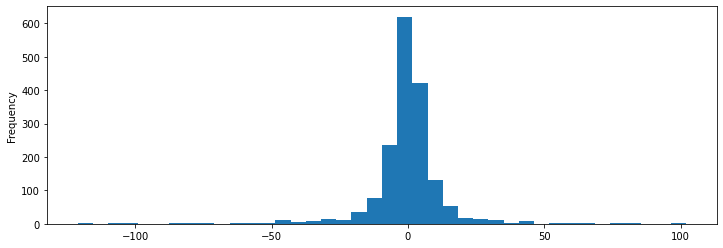

In [329]:
y.plot.hist(bins=40, figsize=(12, 4))

In [330]:
rois = []
for s in range(1000):
    np.random.seed(s)
    preds = np.random.normal(y_train.mean(), y_train.std(), len(y_val))
    rois.append(roi(y_val, preds))
print(np.mean(rois))

-0.005452214633299365


## Modelli

In [0]:
models = {}

In [0]:
ridge_regr = Pipeline([
    ("scale",  StandardScaler()),
    ("regr", Ridge())
])
ridge_regr_grid = {
    "regr__alpha": [0.1, 1, 10, 50]
}
models["ridge_regr"] = (ridge_regr, ridge_regr_grid)

In [0]:
linear_regression = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", None),
    ("regr", LinearRegression())
])
lin_regr_grid = {
    "scale": [None, StandardScaler()],
    "poly__degree": list(range(1, 7))
}
models["lin_regr"] = (linear_regression, lin_regr_grid)

In [0]:
kernel_ridge = Pipeline([
    ("scale", None),
    ("regr", KernelRidge(kernel="rbf"))
])
k_ridge_grid = {
    "scale": [None, StandardScaler()],
    "regr__gamma": [0.001, 0.01, 0.1],
    "regr__alpha": np.logspace(-3, 2, 6)
}
models["k_ridge"] = (kernel_ridge, k_ridge_grid)

## Grid Search per trovare gli iperparametri migliori

In [0]:
tss = TimeSeriesSplit(3)
roi_scorer = make_scorer(roi, greater_is_better=True)
scoring = {
    "roi": roi_scorer
}

In [0]:
results = {}
for model_name, model_data in models.items():
    model = model_data[0]
    grid = model_data[1]
    gs = GridSearchCV(model, grid, scoring=scoring, cv=tss, refit="roi")
    gs.fit(X, y)
    cv_results = pd.DataFrame(gs.cv_results_)
    results[model_name] = cv_results

In [337]:
pd.set_option('display.max_columns', None)
for model_name in models.keys():
    print(f"-------------{model_name}--------------")
    display(results[model_name].sort_values("mean_test_roi", ascending=False).head(5))
    print("\n\n")
    #si puo' fare con un dataframe con indice gerarchico

-------------ridge_regr--------------


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2       0.003226      0.000033         0.002064        0.000033   
3       0.003375      0.000272         0.002148        0.000138   
1       0.003354      0.000115         0.002126        0.000029   
0       0.003662      0.000159         0.002161        0.000009   

  param_regr__alpha                params  split0_test_roi  split1_test_roi  \
2                10   {'regr__alpha': 10}        -0.029932        -0.001615   
3                50   {'regr__alpha': 50}         0.061993        -0.024026   
1                 1    {'regr__alpha': 1}        -0.006495         0.030744   
0               0.1  {'regr__alpha': 0.1}        -0.050108        -0.014879   

   split2_test_roi  mean_test_roi  std_test_roi  rank_test_roi  
2         0.398462       0.122305      0.195614              1  
3         0.109699       0.049222      0.055335              2  
1         0.031438       0.018562      0.017721              3  
0         0.049432      -0.005185      0.041211              4




-------------lin_regr--------------


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
4        0.014746      0.005894         0.004187        0.000210   
5        0.017231      0.001159         0.006380        0.002144   
10       0.314690      0.172424         0.006893        0.000107   
6        0.035177      0.002034         0.004549        0.000086   
7        0.032098      0.006448         0.005314        0.000117   

   param_poly__degree                                        param_scale  \
4                   3                                               None   
5                   3  StandardScaler(copy=True, with_mean=True, with...   
10                  6                                               None   
6                   4                                               None   
7                   4  StandardScaler(copy=True, with_mean=True, with...   

                                               params  split0_test_roi  \
4                  {'poly__degree': 3, 'scale': None}         0.191562   
5   {'poly__degree': 3, 'scale': StandardScaler(co...         0.191562   
10                 {'poly__degree': 6, 'scale': None}         0.342689   
6                  {'poly__degree': 4, 'scale': None}         0.125119   
7   {'poly__degree': 4, 'scale': StandardScaler(co...         0.125119   

    split1_test_roi  split2_test_roi  mean_test_roi  std_test_roi  \
4         -0.165067         0.687484       0.237993      0.349598   
5         -0.165067         0.687484       0.237993      0.349598   
10        -0.159093         0.241984       0.141860      0.216741   
6         -0.010477         0.295892       0.136845      0.125349   
7         -0.010477         0.295892       0.136845      0.125349   

    rank_test_roi  
4               1  
5               1  
10              3  
6               4  
7               4




-------------k_ridge--------------


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7        0.076507      0.054387         0.017969        0.005450   
8        0.071185      0.050539         0.017543        0.006255   
1        0.072262      0.050258         0.017896        0.005393   
14       0.075062      0.055006         0.017604        0.005985   
21       0.076757      0.055131         0.018470        0.005590   

   param_regr__alpha param_regr__gamma  \
7               0.01             0.001   
8               0.01              0.01   
1              0.001             0.001   
14               0.1              0.01   
21                 1              0.01   

                                          param_scale  \
7   StandardScaler(copy=True, with_mean=True, with...   
8                                                None   
1   StandardScaler(copy=True, with_mean=True, with...   
14                                               None   
21  StandardScaler(copy=True, with_mean=True, with...   

                                               params  split0_test_roi  \
7   {'regr__alpha': 0.01, 'regr__gamma': 0.001, 's...        -0.085762   
8   {'regr__alpha': 0.01, 'regr__gamma': 0.01, 'sc...         0.256125   
1   {'regr__alpha': 0.001, 'regr__gamma': 0.001, '...        -0.168346   
14  {'regr__alpha': 0.1, 'regr__gamma': 0.01, 'sca...         0.298136   
21  {'regr__alpha': 1.0, 'regr__gamma': 0.01, 'sca...        -0.018269   

    split1_test_roi  split2_test_roi  mean_test_roi  std_test_roi  \
7          0.400412         0.910933       0.408528      0.406940   
8          0.397554         0.444282       0.365987      0.079992   
1          0.469475         0.694707       0.331946      0.365514   
14         0.277266         0.292547       0.289316      0.008821   
21         0.142085         0.711317       0.278377      0.313056   

    rank_test_roi  
7               1  
8               2  
1               3  
14              4  
21              5

## Modello Migliore
Dall'analisi dei risultati di Grid Search, selezioniamo il modello nella cella seguente.

Questo modello ha un return of investment abbastanza alto(mean_test_roi) e 
che hanno una deviazione standard di questo errore(std_test_roi) bassa. 

Questo e' importante poiche' vuol dire che l'accuratezza delle predizioni fatte da queti modelli non varia
significativamente cambiando i dati, e questo le rende affidabili.

Nell'analisi precedente, vi sono infatti modelli con ROI piu' alto di questo, ma con una deviazione standard motlo alta, e cio' fa si che siano inaffidabili.

In [0]:
#kernel ridge ha il roi migliore e ha una deviazione standard sui fold set motlo bassa
best = Pipeline([
    ("scale", None),
    ("regr", KernelRidge(kernel="rbf", alpha=0.1, gamma=0.01))
])

## Interpretazione dei coefficienti del modello migliore
Dall'analisi dei coefficienti dei parametri riportata di seguito, si nota che la maggiorparte di questi e' negativa e cio' vuol dire che i parametri scelti sono inversamente proporzionali alla variabile da predire, delta.

Come parametri abbiamo usato le differenze tra valore del delta/prezzo e media del delta/prezzo.

Il fatto che i coefficienti di questi parametri siano negativi indica che, visto che il prezzo, nel lasso di pochi gionri (in questo caso 3) rimane circa intorno al suo valore medio, se nei giorni precedenti ha assunto valori sotto quello medio, e' probabile che il giorno attuale risalga e che quindi a fine giornata il pezzo sia piu' alto rispetto a quello di inizio giornata.

In [339]:
best.fit(X, y)
coef = pd.Series(np.dot(X.transpose(),best["regr"].dual_coef_), X.columns)
coef.sort_values(ascending=False)

DeltaVsSMALag3     3545.059666
DeltaVsSMALag2   -12340.342246
DeltaVsSMALag1   -15778.464910
PriceVsSMALag2   -49600.965146
PriceVsSMALag1   -50322.669523
PriceVsSMALag3   -56478.079805
dtype: float64